## Principal Customers Network

- igraph, ego graph, betweenness centrality
- S&P Compustat, Wharton Research Data Services

Author: Terence Lim

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import igraph  # pip3 install cairocffi
from igraph import Graph
from pandas.api import types
import numpy.ma as ma
from numpy.ma import masked_invalid as valid
from itertools import chain
from finds.graph import igraph_draw, igraph_info, igraph_path
from finds.graph import igraph_centrality, igraph_community
from finds.database import SQL
from settings import settings
sql = SQL(**settings['sql'])
logdir = os.path.join(settings['images'], 'supplychain')  # None

## Retrieve principal customers info

In [2]:
year = 2016
cust = sql.read_dataframe(
    f"select gvkey, cgvkey, stic, ctic, conm, cconm from customer"
    f" where srcdate >= {year}0101 and srcdate <= {year}1231")

# To lookup company full name from ticker


In [3]:
lookup = Series(cust['conm'].values, cust['stic'].values)\
         .append(Series(cust['cconm'].values, cust['ctic'].values))\
         .drop_duplicates()


## Construct Directed Graph and show properties

In [7]:
vertices = np.array(list(set(cust['stic']).union(set(cust['ctic']))))
edges = cust[['stic', 'ctic']].values   # direction is supplier to customer
g = Graph(directed=True)          # g.clear()
g.add_vertices(vertices)          # g.add_vertex()
g.add_edges(edges)                # g.add_edge()
dg = g.simplify()
Series(igraph_info(dg)).rename('Simple Graph').to_frame().T

,vertices,edges,density,diameter,simple,directed,global clustering,local clustering,weak components,largest weak,strong components,largest strong
Simple Graph,1830,3041,0.001817,5,True,True,0.005751,0.017642,89,1628,1829,2


##  Display graph

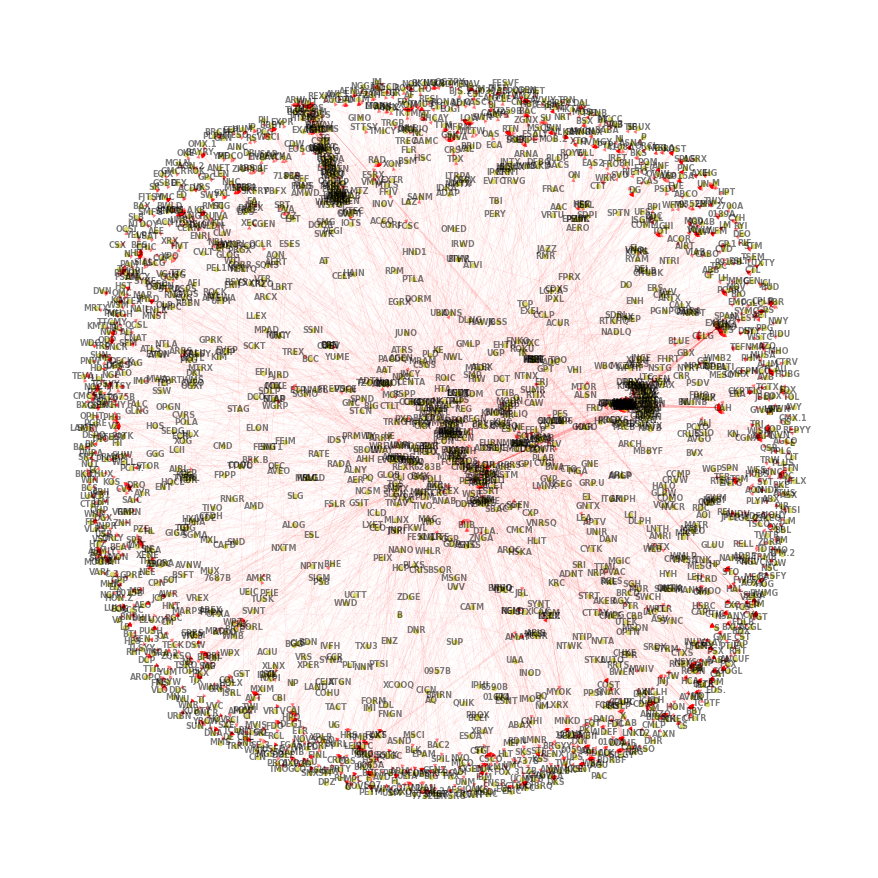

In [8]:
pos = igraph_draw(dg, figsize=(12,12), font_color='k', node_color='y')
plt.savefig(os.path.join(logdir, 'graph.jpg'))
plt.show()

## Maximum edge_betweeness

In [9]:
ebs = dg.edge_betweenness()
max_eb = max(ebs)
[(lookup[dg.es[idx].source_vertex['name']], \
  lookup[dg.es[idx].target_vertex['name']], eb)
 for idx, eb in enumerate(ebs) if eb == max_eb]

[('AMERISOURCEBERGEN CORP', 'EXPRESS SCRIPTS HOLDING CO', 227.0)]

# Show top node centrality properties

In [11]:
centrality = igraph_centrality(dg)
df = DataFrame(centrality, index=dg.vs['name'])
df.index = df.index.map('{:>10s}'.format)     # set print column widths
df.columns = df.columns.map('{:16s}'.format)
n = 5
for c in df.columns:
    print()
    print(df[[c]].sort_values(by=c, ascending=False)[:n].T)


                        AKAM         DHX         KRG         NPO         TEN
outweight               29.0        25.0        21.0        21.0        20.0

                         WMT       RDS.A         MCK         CAH         ABC
inweight               114.0        42.0        42.0        41.0        36.0

                         XON        ZIOP        OGEN        FCSC         CPG
eigenvector              1.0         1.0         1.0         1.0         0.0

                         WMT         AET         CVS         MCK         CAH
pagerank            0.025513    0.020558    0.019632    0.011314    0.010134

                         WMT         BBY         DKS        BBBY        PETM
authority                1.0    0.300293    0.283117     0.26903    0.254883

                         KRG         BRX        BRX1         DDR         RPT
hub                      1.0     0.93217     0.93217    0.747723    0.729558

                         ABC         CAH         CVS        ESRX     

## Ego-graph of max betweenness node with one-step neighbors

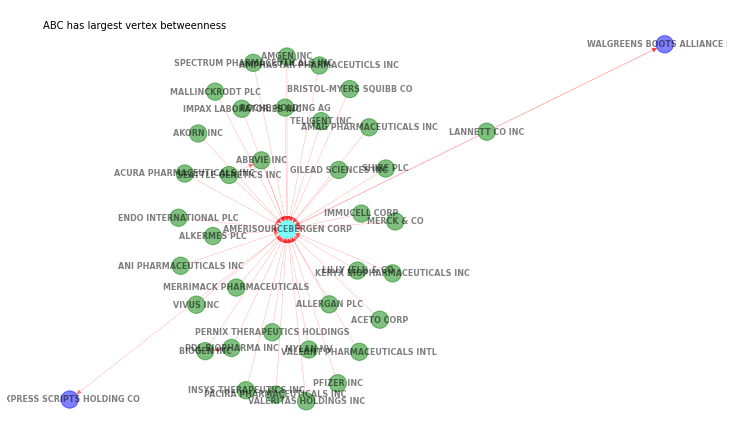

In [12]:
c = 'betweenness'
u = np.argmax(centrality[c])
v = dg.neighbors(u)
ego = dg.induced_subgraph(v + [u])
ego.summary(3)
pos=igraph_draw(
    ego, node_size=300, width=0.5, center_name=g.vs[u]['name'], figsize=(10,6),
    title=f"{dg.vs[u]['name']} has largest vertex {c}",
    node_color={ 
        **{k: 'b' for k in dg.vs[dg.neighbors(u, 'out')]['name']},
        **{k: 'g' for k in dg.vs[dg.neighbors(u, 'in')]['name']},
        **{g.vs[u]['name']: 'cyan'}},
    labels=lookup[ego.vs['name']].to_dict())
plt.savefig(os.path.join(logdir, f'{c}.jpg'))
plt.show()

## Longest shortest path (diameter)

In [13]:
nodes = dg.get_diameter()    # longest shortest path
print(igraph_path(dg, nodes, dg.vs['name'], lookup))

[AGENUS INC] -> [INCYTE CORP] -> [PFIZER INC] -> [CARDINAL HEALTH INC] -> [CVS HEALTH CORP] -> [AETNA INC] 


## Neighbors that complete triangles

In [15]:
neighbors = pd.Series(chain(*[g.neighbors(v) for v in nodes])).value_counts()
triangles = set(neighbors[neighbors > 1].index).difference(nodes)
subnodes = nodes + list(triangles) # with neighbors that complete triangles

## Plot induced subgraph

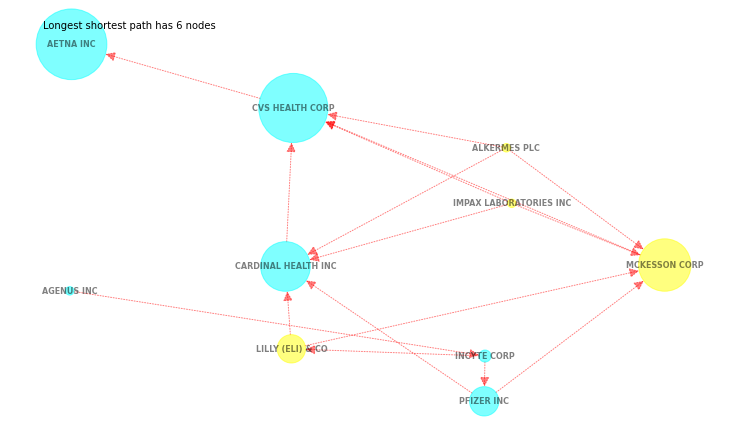

In [16]:
pos = igraph_draw(
    dg.induced_subgraph(subnodes), arrowsize=20, width=1, k=4, 
    title=f"Longest shortest path has {len(nodes)} nodes",
    center_name=dg.vs[nodes[len(nodes)//2]]['name'], figsize=(10,6),
    node_color={
        **{k: 'cyan' for k in dg.vs[nodes]['name']},
        **{k: 'yellow' for k in dg.vs[triangles]['name']}},
    node_size={dg.vs[k]['name']: centrality['pagerank'][k]
               for k in subnodes},
    labels=lookup[dg.vs[subnodes]['name']].to_dict())
plt.savefig(os.path.join(logdir, 'diameter.jpg'))
plt.show()